In [1]:
from __future__ import print_function

import argparse
import torch
import pickle 
import numpy as np 
import os 
import math 
import random 
import sys
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.io

import data 

from sklearn.decomposition import PCA
from torch import nn, optim
from torch.nn import functional as F

from detm import DETM
from utils import nearest_neighbors, get_topic_coherence

import pandas as pd

device: cuda:3
device: cuda:3


In [2]:
from sklearn import cluster
from sklearn import metrics

In [3]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [4]:
root_dir = '/home/yiyi/nlp_tm/'

In [5]:
def load_data(input_dir= os.path.join(root_dir, 'preprocessed_data')):
    token_file = os.path.join(input_dir, 'bow_tokens')
    count_file = os.path.join(input_dir, 'bow_counts')
    time_file = os.path.join(input_dir, 'bow_timestamps')
    tokens = scipy.io.loadmat(token_file)['tokens'].squeeze()
    counts = scipy.io.loadmat(count_file)['counts'].squeeze()
    times = scipy.io.loadmat(time_file)['timestamps'].squeeze()
    
    return tokens, counts, times


In [6]:
tokens, counts, times = load_data()

In [7]:
def _eta_helper(rnn_inp):
    inp = model.q_eta_map(rnn_inp).unsqueeze(1)
    hidden = model.init_hidden()
    output, _ = model.q_eta(inp, hidden)
    output = output.squeeze()
    etas = torch.zeros(model.num_times, model.num_topics).to(device)
    inp_0 = torch.cat([output[0], torch.zeros(model.num_topics,).to(device)], dim=0)
    etas[0] = model.mu_q_eta(inp_0)
    for t in range(1, model.num_times):
        inp_t = torch.cat([output[t], etas[t-1]], dim=0)
        etas[t] = model.mu_q_eta(inp_t)
    return etas

In [9]:
filepath ='results/detm_twitter_K_25_Htheta_800_Optim_adam_Clip_0.0_ThetaAct_relu_Lr_0.005_Bsz_1000_RhoSize_300_L_3_minDF_10_trainEmbeddings_1_val_ppl_2698.4_epoch_4'

In [10]:
model_path = os.path.join('/home/yiyi/nlp_tm/', filepath)

In [11]:
with open(model_path, 'rb') as f:
    model = torch.load(f)

In [12]:
model.to(device)

DETM(
  (t_drop): Dropout(p=0.0, inplace=False)
  (theta_act): ReLU()
  (rho): Linear(in_features=300, out_features=20865, bias=False)
  (q_theta): Sequential(
    (0): Linear(in_features=20890, out_features=800, bias=True)
    (1): ReLU()
    (2): Linear(in_features=800, out_features=800, bias=True)
    (3): ReLU()
  )
  (mu_q_theta): Linear(in_features=800, out_features=25, bias=True)
  (logsigma_q_theta): Linear(in_features=800, out_features=25, bias=True)
  (q_eta_map): Linear(in_features=20865, out_features=200, bias=True)
  (q_eta): LSTM(200, 200, num_layers=3)
  (mu_q_eta): Linear(in_features=225, out_features=25, bias=True)
  (logsigma_q_eta): Linear(in_features=225, out_features=25, bias=True)
)

In [13]:
with open(os.path.join('/home/yiyi/nlp_tm/preprocessed_data', 'vocab.pkl'), 'rb') as f:
        vocab = pickle.load(f)

In [14]:
vocab_size = len(vocab)

In [15]:
len(tokens)

360097

In [16]:
indices = torch.split(torch.tensor(range(len(tokens))), 1000)

In [17]:
# get the centroid of words
keywords=  [ 'immigrant', 'immigrants',  'refugee', 'refugees','asylum',
      'migrant', 'migrants', 'internally displaced', 'UNHCR', 'asylee',
      'asylees', 'Asylee',  'resettled', 'resettlements',
      'immigration', 'Ateh', 're settlement', 'resettle', 'resettles', 'statelessness', 'Hagadera' , 'Domiz',
      'émigré', 'exile', 'displaced person', 'deserter', 'pariah', 'pariahs' ]
# keywords = ['immigrant', 'refugee']
keywords = list(set([k.lower() for k in keywords]))

keywords_selected = []
for k in keywords: 
    if k in vocab:
        keywords_selected.append(k)

In [18]:
keywords_selected

['immigrant',
 'refugees',
 'immigrants',
 'immigration',
 'resettle',
 'exile',
 'unhcr',
 'deserter',
 'pariahs',
 'pariah',
 'asylee',
 'asylum',
 'statelessness',
 'migrants',
 'resettled',
 'migrant',
 'refugee']

In [19]:
def get_centroid_vector(embeddings, keywords):
    # vectors of whole embeddings.
    indexes_keywords = [vocab.index(word) for word in keywords]
    queries = [embeddings[index] for index in indexes_keywords] # vectors of the keywords
    kmeans = cluster.KMeans(n_clusters=1, random_state=0).fit(queries)
    centroid = kmeans.cluster_centers_[0]
    print('centroid size: ', centroid.shape)
    return centroid

In [20]:
from numpy import dot
from numpy.linalg import norm
def cosine_similarity(list_1, list_2):
    cos_sim = dot(list_1, list_2) / (norm(list_1) * norm(list_2))
    return cos_sim

In [21]:
def nearest_neighbors(word, vectors, vocab, num_words):
    index = vocab.index(word)
    query = embeddings[index]
    ranks = vectors.dot(query).squeeze()
    denom = query.T.dot(query).squeeze()
    denom = denom * np.sum(vectors**2, 1)
    denom = np.sqrt(denom)
    ranks = ranks / denom
    print(np.sort(ranks)[::-1][:num_words])
    mostSimilar = []
    [mostSimilar.append(idx) for idx in ranks.argsort()[::-1]]
    nearest_neighbors = mostSimilar[:num_words]
    nearest_neighbors = [vocab[comp] for comp in nearest_neighbors]
    print(nearest_neighbors)
    return nearest_neighbors

In [22]:
model.eval()
with torch.no_grad():
    # rnn_inp = data.get_rnn_input(tokens, counts, times, 8, vocab_size, len(tokens)).to(device)
    # etas = _eta_helper(rnn_inp).to(device)
    embeddings = model.rho.weight
    embeddings= embeddings.cpu().numpy()

In [23]:
indexes_keywords = [vocab.index(word) for word in keywords_selected]
queries = [embeddings[index] for index in indexes_keywords] #

In [24]:
kmeans = cluster.KMeans(n_clusters=1, random_state=0).fit(queries)
centroid = kmeans.cluster_centers_[0]

In [25]:
ranks= embeddings.dot(centroid).squeeze()
denom = centroid.T.dot(centroid).squeeze()
denom = denom*np.sum(embeddings*2, 1)
ranks = ranks/denom
mostSimilar = []
[mostSimilar.append(idx) for idx in ranks.argsort()[::-1]]
nearest_neighbors = mostSimilar[:20]
nearest_neighbors = [vocab[comp] for comp in nearest_neighbors]
nearest_neighbors

['srilankan',
 'lancashire',
 'startrek',
 'boutique',
 'gel',
 'melanie',
 'mel',
 'minister',
 'amazon',
 'uns',
 'hive',
 'upto',
 'gee',
 'horizoneurope',
 'envelope',
 'irl',
 'euroland',
 'rifle',
 'blink',
 'troops']

In [26]:
neigh_indices = [vocab.index(word) for word in nearest_neighbors]
neigh_q = [embeddings[index] for index in neigh_indices] 

In [27]:
len(neigh_q)

20

In [28]:
len(queries)

17

In [29]:
len(keywords_selected)

17

In [30]:
queries.append(centroid)

In [31]:
len(queries)

18

In [32]:
n = queries+neigh_q
n_arr = np.array(n)

In [33]:
n_arr.shape

(38, 300)

In [34]:
ks =keywords_selected+['centroid']+nearest_neighbors

In [35]:
len(ks)

38

In [36]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=7)
T = tsne.fit_transform(n_arr)

In [37]:
colors = ['blue' for x in range(0,17)]+['red']+['orange' for x in range(0,20) ]

In [38]:
len(colors)

38

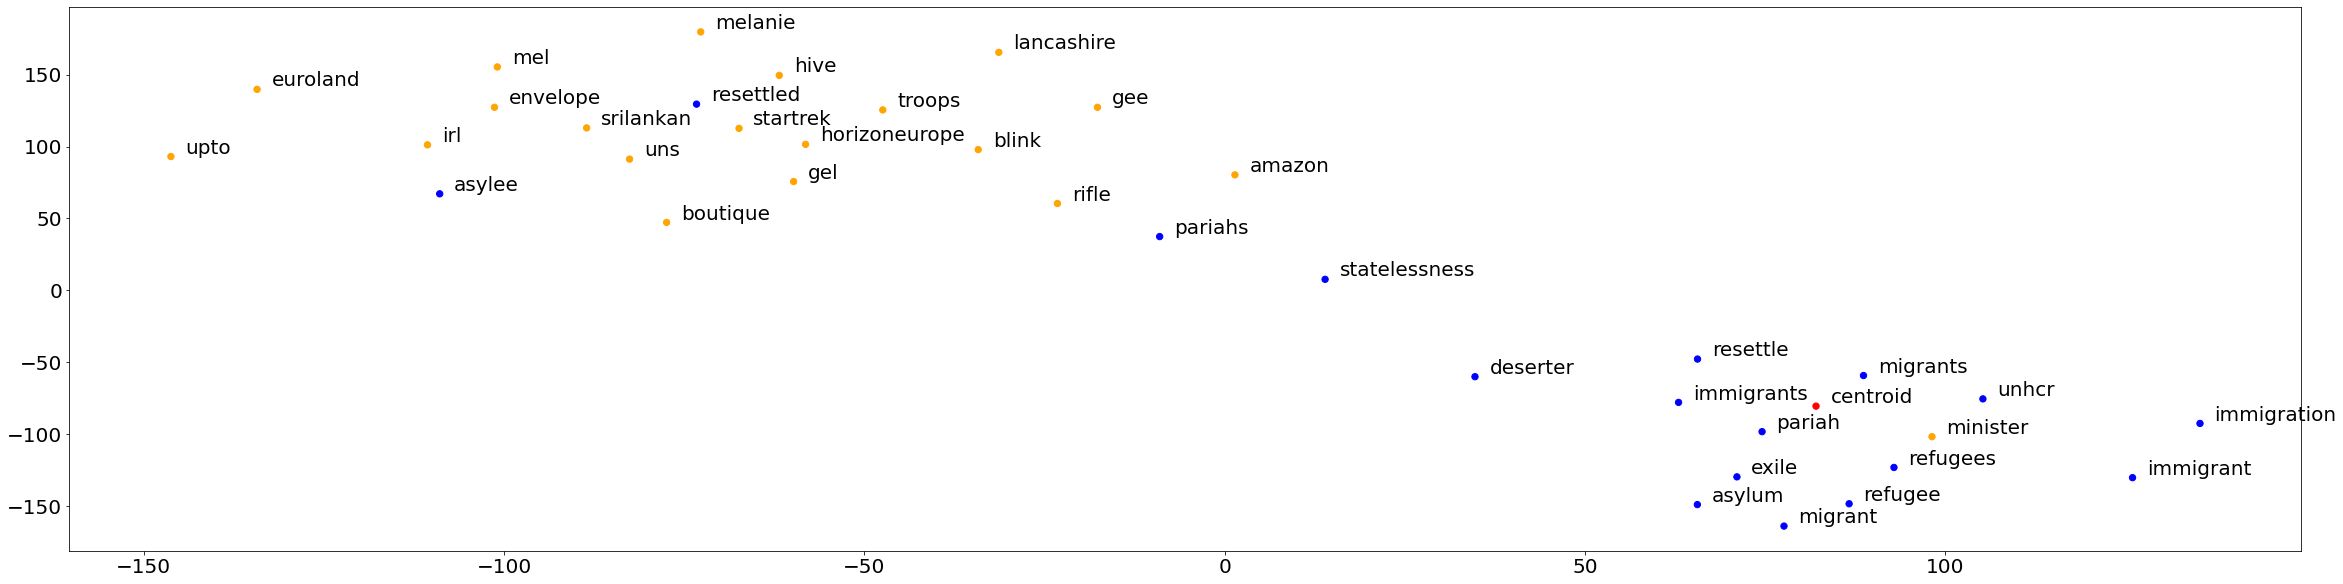

In [52]:
plt.figure(figsize=(40,10))
plt.scatter(T[:, 0], T[:, 1], s=40, c=colors)

for label, x, y in zip(ks, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+2, y+2), xytext=(0, 0), textcoords='offset points', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('images/dist_emb_detm_k-25.png')

In [42]:
confidences =[]
model.eval()
with torch.no_grad():
    rnn_inp = data.get_rnn_input(tokens, counts, times, 8, vocab_size, len(tokens)).to(device)
    etas = _eta_helper(rnn_inp).to(device)
#     embeddings = model.rho.weight
#     embeddings= embeddings.cpu().numpy()
#     indexes_keywords = [vocab.index(word) for word in keywords]
#     queries = [embeddings[index] for index in indexes_keywords] # vectors of the keywords
#     print(cosine_similarity(queries[0], queries[1]))
#     centroid = get_centroid_vector(embeddings, keywords_selected)

    for idx, ind in enumerate(indices):
        data_batch, times_batch = data.get_batch(
                        tokens, counts, ind, len(vocab),300, temporal=True, times=times)
        sums = data_batch.sum(1).unsqueeze(1)
        normalized_data_batch = data_batch / sums
        eta_td = etas[times_batch.type('torch.LongTensor')].to(device)
        inp = torch.cat([eta_td, normalized_data_batch], dim=1).to(device)
        q_theta = model.q_theta(inp) # 1000, 800
        lr = nn.Linear(q_theta.shape[1], 300).to(device)
        mu_theta = lr(q_theta).cpu().numpy()
        for i in mu_theta:
            cos = cosine_similarity(i, centroid)
            confidences.append(cos)

        # mu_theta = model.mu_q_theta(q_theta) # 1000, 75
        print(q_theta.shape)
        print(mu_theta.shape)



/home/yiyi/nlp_tm/models/DETM/data.py:117: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370117127/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  tmp = (times_batch == t).nonzero()


idx: 0/361
idx: 20/361
idx: 40/361
idx: 60/361
idx: 80/361
idx: 100/361
idx: 120/361
idx: 140/361
idx: 160/361
idx: 180/361
idx: 200/361
idx: 220/361
idx: 240/361
idx: 260/361
idx: 280/361
idx: 300/361
idx: 320/361
idx: 340/361
idx: 360/361
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
torch.Size([1000, 800])
(1000, 300)
tor

In [28]:
len([x for x in confidences if x>0])

179256

In [45]:
len([x for x in confidences if x>0])

176778

In [46]:
df = pd.read_csv(os.path.join(root_dir, 'datasets/df_detm_topics_k25.csv'), index_col=0)

In [47]:
df.head()

,text_id,year_id,country_code,id.1,text,created_at,geo,author_id,entities,year,month,day,preprocessed_text,topic
id,,,,,,,,,,,,,,
285908615561363456,"[13807, 12242, 16517, 4854, 16885, 13840, 7284...",0,GB,285908615561363456,"Completely missed the New Year beginning, too ...",2013-01-01T00:41:40.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",174028844,"{'hashtags': [{'start': 59, 'end': 80, 'tag': ...",2013,1,1,completely miss new year beginning engross car...,17
285909630868152320,"[11403, 16517, 13618, 1431, 1404, 1881]",0,DE,285909630868152320,happy new year all of you who lives in #europe...,2013-01-01T00:45:42.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",615040794,"{'hashtags': [{'start': 39, 'end': 46, 'tag': ...",2013,1,1,happy new year live europe party start right,17
285915248383361026,"[638, 2601, 20286]",0,GB,285915248383361026,Damien Sandow is awesome #YoureWelcome,2013-01-01T01:08:01.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",73127632,"{'annotations': [{'start': 0, 'end': 12, 'prob...",2013,1,1,damien sandow awesome yourewelcome,17
285921849446117376,"[17018, 9987]",0,GB,285921849446117376,Ryan was looking at me like I needed to be in ...,2013-01-01T01:34:15.000Z,"{'place_id': 'a3f4491c1a3bfe66', 'coordinates'...",398595226,"{'annotations': [{'start': 0, 'end': 3, 'proba...",2013,1,1,ryan look like need asylum troublemaker come,17
285922536942866432,"[2721, 16517, 12121]",0,GB,285922536942866432,#welcome #to #2013 #i #hope #this #year #is #b...,2013-01-01T01:36:59.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",191530036,"{'hashtags': [{'start': 0, 'end': 8, 'tag': 'w...",2013,1,1,welcome hope year well litte world know,17


In [48]:
len(df)

360097

In [49]:
df['cossim']= confidences

In [59]:
df[df['cossim']>=0.01]

,text_id,year_id,country_code,id.1,text,created_at,geo,author_id,entities,year,month,day,preprocessed_text,topic,cossim
id,,,,,,,,,,,,,,,
285908615561363456,"[13807, 12242, 16517, 4854, 16885, 13840, 7284...",0,GB,285908615561363456,"Completely missed the New Year beginning, too ...",2013-01-01T00:41:40.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",174028844,"{'hashtags': [{'start': 59, 'end': 80, 'tag': ...",2013,1,1,completely miss new year beginning engross car...,17,0.056427
285909630868152320,"[11403, 16517, 13618, 1431, 1404, 1881]",0,DE,285909630868152320,happy new year all of you who lives in #europe...,2013-01-01T00:45:42.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",615040794,"{'hashtags': [{'start': 39, 'end': 46, 'tag': ...",2013,1,1,happy new year live europe party start right,17,0.046433
285915248383361026,"[638, 2601, 20286]",0,GB,285915248383361026,Damien Sandow is awesome #YoureWelcome,2013-01-01T01:08:01.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",73127632,"{'annotations': [{'start': 0, 'end': 12, 'prob...",2013,1,1,damien sandow awesome yourewelcome,17,0.048438
285921849446117376,"[17018, 9987]",0,GB,285921849446117376,Ryan was looking at me like I needed to be in ...,2013-01-01T01:34:15.000Z,"{'place_id': 'a3f4491c1a3bfe66', 'coordinates'...",398595226,"{'annotations': [{'start': 0, 'end': 3, 'proba...",2013,1,1,ryan look like need asylum troublemaker come,17,0.043933
285922536942866432,"[2721, 16517, 12121]",0,GB,285922536942866432,#welcome #to #2013 #i #hope #this #year #is #b...,2013-01-01T01:36:59.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",191530036,"{'hashtags': [{'start': 0, 'end': 8, 'tag': 'w...",2013,1,1,welcome hope year well litte world know,17,0.052431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344790047673999362,"[3182, 8938, 10578, 7902, 1404, 10296, 9463, 1...",7,ES,1344790047673999362,Clare Fox the ex communist then Brexit party l...,2020-12-31T23:38:27.000Z,"{'place_id': 'b5014b0a70dd1cc2', 'place': {'ge...",196307493,"{'annotations': [{'start': 0, 'end': 8, 'proba...",2020,12,31,clare fox ex communist brexit party leader est...,55,0.010286
1344790568510115841,"[12183, 20621, 5389, 3949, 9602, 18589, 6566, ...",7,GB,1344790568510115841,Here we go. We’re now no longer at the EU’s ‘m...,2020-12-31T23:40:31.000Z,"{'place_id': '2a3f152d1ac5044a', 'place': {'fu...",34258136,"{'annotations': [{'start': 39, 'end': 40, 'pro...",2020,12,31,long eu mercy watch pivot new bogeyman immigra...,46,0.010522
1344791154005573632,"[1431, 10434, 1206, 6258, 13960, 2093, 8090, 9...",7,GB,1344791154005573632,As #Europe is one hour ahead of #Britain they ...,2020-12-31T23:42:50.000Z,"{'place_id': '609de05ff9db5cfe', 'place': {'fu...",108713501,"{'hashtags': [{'start': 3, 'end': 10, 'tag': '...",2020,12,31,europe hour ahead britain celebrate newyear bl...,55,0.010707


In [95]:
df.to_csv(os.path.join(root_dir, 'datasets/df_detm_topics_k25_confidence.csv'))

In [66]:
threshold = 0

In [75]:
import seaborn as sns
from matplotlib import pyplot as plt

In [73]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

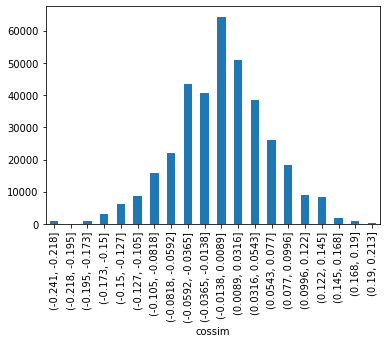

In [80]:
df['text'].groupby(pd.cut(df['cossim'], 20)).count().plot(kind='bar')

In [84]:
df['topic'].value_counts()

69    90796
55    86117
37    52921
51    40866
17    28788
48    23441
7     17286
22    13545
72     1853
0      1607
3       876
56      386
46      299
21      196
19      168
54      158
64      115
67       96
58       93
61       70
62       58
63       54
59       54
36       48
35       42
53       32
32       29
14       26
15       23
74       22
13       10
8         9
71        6
60        3
47        2
42        1
9         1
Name: topic, dtype: int64

In [86]:
samples = df[df['cossim']>=0.01]

In [87]:
len(samples)

151256

In [88]:
samples['topic'].value_counts()

69    37890
55    34818
37    18984
51    18322
48    13894
17     9562
7      8303
22     6597
72      808
0       797
3       318
56      150
21      148
46      146
19       76
54       62
67       62
64       59
58       46
61       29
36       27
63       22
62       22
35       20
32       16
14       16
59       13
15       11
74       10
53       10
8         7
13        4
71        4
47        2
9         1
Name: topic, dtype: int64

In [93]:
samples[samples['topic']==13]

,text_id,year_id,country_code,id.1,text,created_at,geo,author_id,entities,year,month,day,preprocessed_text,topic,cossim
id,,,,,,,,,,,,,,,
739795555598098432,"[6487, 691, 11443, 6487, 691]",3,ES,739795555598098432,#madrid #spain #palaciodecibeles #refugeeswelc...,2016-06-06T12:26:19.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",15330946,"{'urls': [{'start': 66, 'end': 89, 'url': 'htt...",2016,6,6,madrid spain palaciodecibele refugeeswelcome m...,13,0.017466
781148016094748672,"[6959, 9754, 1431, 691, 6959, 691]",3,ES,781148016094748672,🏝🏝🏝 #alicante #beach #europe #spain @ Alicante...,2016-09-28T15:06:14.000Z,"{'place_id': '2e858e47881ddc48', 'coordinates'...",159639553,"{'annotations': [{'start': 41, 'end': 55, 'pro...",2016,9,28,alicante beach europe spain alicante spain,13,0.055720
807615988631900160,"[1431, 691, 6487, 6487, 691]",3,ES,807615988631900160,"#europe #spain🇪🇸 #madrid🇪🇸 @ Madrid, Spain htt...",2016-12-10T16:00:31.000Z,"{'coordinates': {'type': 'Point', 'coordinates...",31822685,"{'annotations': [{'start': 33, 'end': 45, 'pro...",2016,12,10,europe spain madrid madrid spain,13,0.118667
813903053908647936,"[691, 691, 13819, 12634, 10369, 181, 691, 5532]",3,ES,813903053908647936,"Spain | Spain won't be taking in Muna, the mi...",2016-12-28T00:23:04.000Z,"{'place_id': '206c436ce43a43a3', 'coordinates'...",186478529,"{'urls': [{'start': 115, 'end': 138, 'url': 'h...",2016,12,28,spain spain wo take muna migrant child bear fr...,13,0.115506


In [62]:
samples = df[df['cossim']>=0.01].sample(30)

In [63]:
list(zip(samples.text, samples.cossim, samples.topic))

[("#MusketeersEurope Last one of my screenshots of #TheMusketeers S3 #Set with a lot action showing how perfect #Cast and #Crew worked. It's one of the triumphant ⚜️ final scenes S3ep6 Death Of A Hero #Treville #HugoSpeer #Porthos #HowardCharles #Athos #TomBurke #ThrowbackThursay https://t.co/Yhxpuo6SJt",
  0.023792373160939198,
  69),
 ('“@TheMoeDee: Today around exactly half of the population of syria is refugees. Either internally or externally.”',
  0.06641904848980816,
  37),
 ('The @EU_Commission follows closely the epidemiological situation in the Sahrawi refugee camps &amp; has well-functioning communication channels with the #Sahrawi_Red_Crescent responsible for aid delivery in the camps and with all relevant UNAs, including #MINURSO #freewesternsahara https://t.co/gaZ7rMBGtM',
  0.07898203566995537,
  55),
 ("@WebsterFrank @Fox_Claire @ajayjagota @brexitparty_uk Where was the racism? I didn't vote Brexit because I'm a racist. I think you are equating control of immigration wi